In [36]:
!pip install pymed

In [37]:
!pip install transformers

In [38]:
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import time
import random
from pymed import PubMed
import transformers
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import os
import argparse

%matplotlib inline

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
seed = 123

# Load custom modules

In [41]:
user = "jessicaw9910"
repo = "NLU_project"
src_dir = "src"
pyfile = "main.py"

url = f"https://raw.githubusercontent.com/{user}/{repo}/main/{src_dir}/{pyfile}"
!wget --no-cache --backups=1 {url}

# result = subprocess.run(["wget", "--no-cache", "--backups=1", url], stderr=subprocess.PIPE, stdout=subprocess.PIPE)
# print(result.stderr.decode("utf-8"))

--2022-05-12 19:18:16--  https://raw.githubusercontent.com/jessicaw9910/NLU_project/main/src/main.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5664 (5.5K) [text/plain]
Saving to: ‘main.py’

main.py             100%[===================>]   5.53K  --.-KB/s    in 0s      

2022-05-12 19:18:16 (69.0 MB/s) - ‘main.py’ saved [5664/5664]



In [42]:
pyfile = "utils.py"

url = f"https://raw.githubusercontent.com/{user}/{repo}/main/{src_dir}/{pyfile}"
!wget --no-cache --backups=1 {url}

--2022-05-12 19:18:17--  https://raw.githubusercontent.com/jessicaw9910/NLU_project/main/src/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8602 (8.4K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   8.40K  --.-KB/s    in 0s      

2022-05-12 19:18:17 (88.9 MB/s) - ‘utils.py’ saved [8602/8602]



In [43]:
from utils import *
from main import *

# Load Data

If have run retrieve abstracts previously

In [44]:
df_mad = pd.read_csv('/content/drive/My Drive/nlu_project/assets/df_mad.csv')

In [45]:
df_abstracts = pd.read_csv('/content/drive/My Drive/nlu_project/assets/articles.csv')

# Retrieve Abstracts

Referred to implementation [here](https://stackoverflow.com/questions/65148151/when-i-try-to-get-all-article-details-from-query-on-pubmed-to-pandas-dataframe-a).

In [10]:
df_mad = pd.read_csv('/content/drive/My Drive/nlu_project/assets/df_mad.csv')

In [ ]:
## run only first time
abstract_list, drug, tcga = save_abstracts(df_mad, first_pass=True)

In [ ]:
## repeat as many times as necessary until complete
abstract_list, drug, tcga = save_abstracts(df_mad, drug, tcga, abstract_list)

In [ ]:
df_abstract = create_dataframe(abstract_list, df_mad)

## split data into train, val, test
df_abstracts = annotate_splits(df_abstracts, seed=seed)
# df_test = df_abstracts.copy()
# sum([i != j for i, j in zip(list(df_abstracts['set']), list(df_test['set']))])

In [ ]:
df_articles.to_csv('/content/drive/My Drive/nlu_project/assets/articles.csv', index=False)

# Analyze Abstracts

In [ ]:
df_abstracts['id'].value_counts().head(10)

Gemcitabine_Lung squamous cell carcinoma           426
Topotecan_Small cell lung cancer                   425
Docetaxel_Head and Neck squamous cell carcinoma    415
Docetaxel_Esophageal carcinoma                     414
Tamoxifen_Breast invasive carcinoma                413
Irinotecan_Small cell lung cancer                  409
Gemcitabine_Bladder Urothelial Carcinoma           406
Sorafenib_Kidney renal clear cell carcinoma        406
Gemcitabine_Lung adenocarcinoma                    403
Oxaliplatin_Stomach adenocarcinoma                 403
Name: id, dtype: int64

In [ ]:
df_abstracts.shape

(59791, 7)

In [ ]:
sum(df_abstracts['id'].value_counts() > 400)

10

In [ ]:
df_mad.groupby(['abstract_bool', 'SENSITIVE']).size().reset_index(name='n')

,abstract_bool,SENSITIVE,n
0,False,False,2264
1,False,True,918
2,True,False,793
3,True,True,762


In [ ]:
## distribution of sensitivity by abstract for stacked bar chart
df_count = df_mad.groupby(['abstract_bool', 'SENSITIVE']).size().reset_index(name='n')
vals = [('Total', False, df_mad['SENSITIVE'].value_counts()[0]), 
        ('Total', True, df_mad['SENSITIVE'].value_counts()[1])]
df_add = pd.DataFrame(vals, columns=df_count.columns)
df_count = df_count.append(df_add, ignore_index = True)
df_count = df_count.pivot(index='abstract_bool', columns='SENSITIVE', values='n')

In [ ]:
df_count.div(df_count.sum(axis=1), axis=0)

SENSITIVE,False,True
abstract_bool,,
False,0.903834,0.096166
True,0.743408,0.256592
Total,0.851172,0.148828


In [ ]:
df_count

SENSITIVE,False,True
abstract_bool,,
False,2264,918
True,793,762
Total,3057,1680


In [ ]:
sum(df_abstracts['SENSITIVE']) / len(df_abstracts['SENSITIVE'])

0.4060477329363951

In [ ]:
n_list = [256, 512]
for n in n_list:
  no_greater = sum([len(i.split(' ')) > n for i in df_abstracts['abstract']])
  perc_greater = no_greater / len(df_abstracts['abstract'])
  print(f'{no_greater:} abstracts ({perc_greater:1.5%}) > {n:} tokens')
  print()

14874 abstracts (24.87665%) > 256 tokens

338 abstracts (0.56530%) > 512 tokens



In [47]:
df_abstracts['set'].value_counts()

train         43431
test           8225
validation     8135
Name: set, dtype: int64

In [48]:
df_abstracts['set'].value_counts() / len(df_abstracts['set'])

train         0.726380
test          0.137563
validation    0.136057
Name: set, dtype: float64

# Baseline Results

In [ ]:
list_acc, list_f1 = run_baseline(df_mad, seed)

In [ ]:
np.mean(list_f1)

0.2566040100250626

In [ ]:
np.mean(list_acc)

0.3814983922829582

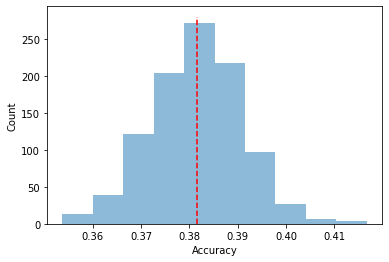

In [ ]:
plt.hist(list_acc, alpha=0.5, );
plt.vlines(np.mean(list_acc), ymin=0, ymax=280, 
           color='r', linestyles='dashed');
plt.savefig('images/baseline_hist.png');
plt.xlabel('Accuracy');
plt.ylabel('Count');

# Compare Results

In [12]:
path_metric = '/content/drive/My Drive/nlu_project/assets/metrics'

In [30]:
def aggregate_metrics(path):
  metric_list = os.listdir(path)
  # print(metric_list)

  df_eval = pd.DataFrame()
  df_train = pd.DataFrame()
  df_summary = pd.DataFrame()

  for metric in metric_list:
    ## get relevant file
    df = pd.read_csv(path + '/' + metric)

    ## extract file source info
    source = metric.split('_df')[0]
    df['source'] = source

    ## add to relevant dataframe
    if 'summary' in metric:
      df_summary = pd.concat([df_summary, df], ignore_index=True)
    if 'eval' in metric:
      df_eval = pd.concat([df_eval, df], ignore_index=True)
    if 'train' in metric:
      df_train = pd.concat([df_train, df], ignore_index=True)

  dfs = [df_summary, df_eval, df_train]
  for df in dfs:
      # df['model'] = [i[0] for i in list(df_train['source'].str.split('_'))]
      df['model'] = df['source'].apply(lambda x: x.split('_')[0])    
      df['max_length'] = df['source'].apply(lambda x: int(x.split('_')[1]))
      df.sort_values('max_length').sort_values('model', inplace=True)

  # # df_train['model'] = [i[0] for i in list(df_train['source'].str.split('_'))]
  # df_train['model'] = df_train['source'].apply(lambda x: x.split('_')[0])
  # df_train['max_length'] = df_train['source'].apply(lambda x: int(x.split('_')[1]))

  # df_summary['model'] = df_eval['source'].apply(lambda x: x.split('_')[0])
  # df_eval['model'] = df_eval['source'].apply(lambda x: x.split('_')[0])
  # df_eval['max_length'] = df_eval['source'].apply(lambda x: int(x.split('_')[1]))

  return df_summary, df_eval, df_train

In [31]:
df_summary, df_eval, df_train = aggregate_metrics(path_metric)

In [49]:
df_summary

,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss,epoch,step,source,model,max_length
0,6703.4985,19.437,1.215,3.428153e+16,0.154162,3.0,8145,BlueBERT_512_3_16_1e-05_0.1,BlueBERT,512
1,10549.1691,12.351,0.772,3.428153e+16,0.270611,3.0,8145,BioBERT_512_3_16_1e-05_0.1,BioBERT,512
2,4998.7232,26.065,1.629,1.714076e+16,0.334190,3.0,8145,BioBERT_256_3_16_1e-05_0.1,BioBERT,256
3,10520.4564,12.385,0.774,3.428153e+16,0.269285,3.0,8145,SciBERT_512_3_16_1e-05_0.1,SciBERT,512
4,5021.4719,25.947,1.622,1.714076e+16,0.302066,3.0,8145,SciBERT_256_3_16_1e-05_0.1,SciBERT,256
5,7347.1354,17.734,1.109,3.428153e+16,0.174605,3.0,8145,BioMed-RoBERTa_512_3_16_1e-05_0.1,BioMed-RoBERTa,512
6,4359.0681,29.890,1.869,1.714076e+16,0.276955,3.0,8145,BioMed-RoBERTa_256_3_16_1e-05_0.1,BioMed-RoBERTa,256
7,4949.5141,26.324,1.646,1.714076e+16,0.340362,3.0,8145,BlueBERT_256_3_16_1e-05_0.1,BlueBERT,256


In [67]:
df_summary['runtime_hours'] = df_summary['train_runtime'] / 3600

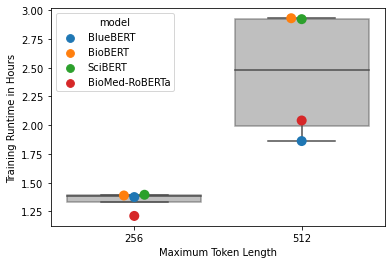

In [68]:
ax = sns.boxplot(x='max_length', y='runtime_hours', data=df_summary, color='grey', boxprops=dict(alpha=.5))
ax = sns.swarmplot(x='max_length', y='runtime_hours', hue='model', data=df_summary, size=10)
ax.set_xlabel('Maximum Token Length')
ax.set_ylabel('Training Runtime in Hours')
plt.savefig('/content/drive/My Drive/nlu_project/images/runtime.svg');
plt.show()

In [26]:
df_train.head(10)

,epoch,learning_rate,loss,step,source,model,max_length
0,0.04,0.000002,0.7081,100,BlueBERT_512_3_16_1e-05_0.1,BlueBERT,512
1,0.07,0.000004,0.6702,200,BlueBERT_512_3_16_1e-05_0.1,BlueBERT,512
2,0.11,0.000006,0.6713,300,BlueBERT_512_3_16_1e-05_0.1,BlueBERT,512
3,0.15,0.000008,0.6267,400,BlueBERT_512_3_16_1e-05_0.1,BlueBERT,512
4,0.18,0.000010,0.5314,500,BlueBERT_512_3_16_1e-05_0.1,BlueBERT,512
5,0.22,0.000010,0.4559,600,BlueBERT_512_3_16_1e-05_0.1,BlueBERT,512
6,0.26,0.000010,0.3957,700,BlueBERT_512_3_16_1e-05_0.1,BlueBERT,512
7,0.29,0.000010,0.3586,800,BlueBERT_512_3_16_1e-05_0.1,BlueBERT,512
8,0.33,0.000009,0.3786,900,BlueBERT_512_3_16_1e-05_0.1,BlueBERT,512
9,0.37,0.000009,0.3356,1000,BlueBERT_512_3_16_1e-05_0.1,BlueBERT,512


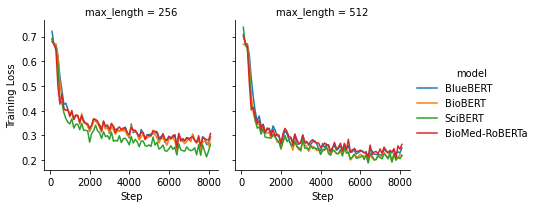

In [27]:
n = len(df_train['max_length'].unique())

g = sns.FacetGrid(df_train, col='max_length', hue='model', col_wrap=n)
g.map(sns.lineplot, 'step', 'loss')
g.add_legend()
g.set_axis_labels('Step', 'Training Loss')
plt.savefig('/content/drive/My Drive/nlu_project/images/train_accuracy.svg');
plt.show();

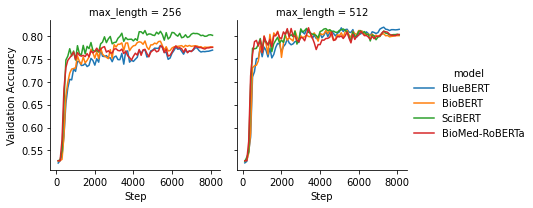

In [33]:
g = sns.FacetGrid(df_eval, col='max_length', hue='model', col_wrap=n)
g.map(sns.lineplot, 'step', 'eval_accuracy')
g.add_legend()
g.set_axis_labels('Step', 'Validation Accuracy')
plt.savefig('/content/drive/My Drive/nlu_project/images/val_accuracy.svg');
plt.show();

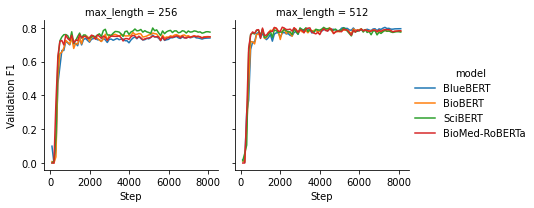

In [34]:
g = sns.FacetGrid(df_eval, col='max_length', hue='model', col_wrap=n)
g.map(sns.lineplot, 'step', 'eval_f1')
g.add_legend()
g.set_axis_labels('Step', 'Validation F1')
plt.savefig('/content/drive/My Drive/nlu_project/images/val_f1.svg');
plt.show();

In [35]:
model_list = ['BioBERT', 'BioMed-RoBERTa', 'BlueBERT', 'SciBERT']
maxlength_list = [512, 256]

for maxlength in maxlength_list:
  for model in model_list:
    f1_max = df_eval.loc[(df_eval['model'] == model) & (df_eval['max_length'] == maxlength), 'eval_f1'].max()
    acc_max = df_eval.loc[(df_eval['model'] == model) & (df_eval['max_length'] == maxlength), 'eval_accuracy'].max()

    print(f'{model:}, {maxlength:} Accuracy: {acc_max:.3%}')
    print(f'{model:}, {maxlength:} F1: {f1_max:.3%}')
    print()

BioBERT, 512 Accuracy: 81.401%
BioBERT, 512 F1: 80.063%

BioMed-RoBERTa, 512 Accuracy: 81.832%
BioMed-RoBERTa, 512 F1: 80.349%

BlueBERT, 512 Accuracy: 81.955%
BlueBERT, 512 F1: 80.248%

SciBERT, 512 Accuracy: 81.696%
SciBERT, 512 F1: 80.253%

BioBERT, 256 Accuracy: 78.943%
BioBERT, 256 F1: 77.223%

BioMed-RoBERTa, 256 Accuracy: 77.873%
BioMed-RoBERTa, 256 F1: 75.846%

BlueBERT, 256 Accuracy: 77.984%
BlueBERT, 256 F1: 75.679%

SciBERT, 256 Accuracy: 81.217%
SciBERT, 256 F1: 79.866%



In [153]:
df_eval.tail()

,epoch,eval_accuracy,eval_f1,eval_loss,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,eval_steps_per_second,step,source,model,max_length
643,2.84,0.765950,0.733109,0.581069,0.795074,0.680104,36.7052,221.631,13.867,7700,BlueBERT_256_3_16_1e-05_0.1,BlueBERT,256
644,2.87,0.766687,0.737192,0.575405,0.788274,0.692328,36.7431,221.402,13.853,7800,BlueBERT_256_3_16_1e-05_0.1,BlueBERT,256
645,2.91,0.766933,0.738483,0.577278,0.786197,0.696229,36.6584,221.914,13.885,7900,BlueBERT_256_3_16_1e-05_0.1,BlueBERT,256
646,2.95,0.768162,0.739215,0.579603,0.789194,0.695189,36.6767,221.803,13.878,8000,BlueBERT_256_3_16_1e-05_0.1,BlueBERT,256
647,2.98,0.769392,0.739661,0.581168,0.792919,0.693108,36.6339,222.062,13.894,8100,BlueBERT_256_3_16_1e-05_0.1,BlueBERT,256


In [1]:
link_list = ['scibert_scivocab_uncased', 'dmis-lab/biobert-v1.1', 'allenai/biomed_roberta_base', 'bluebert_pubmed_uncased_L-12_H-768_A-12']

for link in link_list:
  tokenizer = transformers.AutoTokenizer.from_pretrained(link)

NameError: ignored

# Models

In [ ]:
scibert_path = '/content/drive/My Drive/nlu_project/SciBERT'

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
model = transformers.BertForSequenceClassification.from_pretrained('allenai/scibert_scivocab_uncased', num_labels=2)

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/223k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

In [ ]:
class AbstractDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
encoded_train = tokenizer(list(df_abstracts.loc[df_abstracts['set'] == 'train', 'abstract']),
                          max_length=256, truncation=True, padding=True, return_tensors='pt')
encoded_val = tokenizer(list(df_abstracts.loc[df_abstracts['set'] == 'validation', 'abstract']),
                        max_length=256, truncation=True, padding=True, return_tensors='pt')
encoded_test = tokenizer(list(df_abstracts.loc[df_abstracts['set'] == 'test', 'abstract']),
                         max_length=256, truncation=True, padding=True, return_tensors='pt')

In [ ]:
label_train = list(df_abstracts.loc[df_abstracts['set'] == 'train', 'SENSITIVE'])
label_val = list(df_abstracts.loc[df_abstracts['set'] == 'validation', 'SENSITIVE'])
label_test = list(df_abstracts.loc[df_abstracts['set'] == 'test', 'SENSITIVE'])

label_train = [int(x == True) for x in label_train]
label_val = [int(x == True) for x in label_val]
label_test = [int(x == True) for x in label_test]

# label_train = torch.FloatTensor([int(x == True) for x in label_train])
# label_val = torch.FloatTensor([int(x == True) for x in label_val])
# label_test = torch.FloatTensor([int(x == True) for x in label_test])

In [ ]:
dataset_train = AbstractDataset(encoded_train, label_train)
dataset_val = AbstractDataset(encoded_val, label_val)
dataset_test = AbstractDataset(encoded_test, label_test)

In [ ]:
#CUDA_LAUNCH_BLOCKING=1

path = os.path.join(scibert_path, time.strftime("%Y%m%d-%H%M%S"))
os.mkdir(path)
os.mkdir(path + '/results')
os.mkdir(path + '/logs')

training_args = transformers.TrainingArguments(
    learning_rate = 1e-5,
    num_train_epochs=3,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=32,   
    warmup_steps=500,
    weight_decay=0.2,               
    output_dir=path+'/results',      
    overwrite_output_dir=True,
    save_total_limit=5,
    evaluation_strategy='steps',
    save_strategy='steps',
    load_best_model_at_end=True,    
    logging_dir=path + '/logs',            
    logging_steps=100
)

trainer = transformers.Trainer(
    model=model,                         
    args=training_args,
    compute_metrics=compute_metrics,                  
    train_dataset=dataset_train,         
    eval_dataset=dataset_val             
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 43431
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 8145
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,0.673100,0.741578,0.527597,0.009791,0.527778,0.004941
200,0.669000,0.729029,0.527966,0.004149,0.727273,0.002081
300,0.673300,0.692906,0.541856,0.185355,0.580822,0.110273
400,0.605400,0.646881,0.639336,0.594639,0.634247,0.559688
500,0.455200,0.588348,0.735956,0.712757,0.733554,0.693108
600,0.429700,0.573298,0.737800,0.734998,0.703616,0.769311
700,0.372700,0.502672,0.773325,0.753674,0.774787,0.733680
800,0.366400,0.519432,0.759066,0.751773,0.732659,0.771912
900,0.357200,0.551471,0.762999,0.737616,0.773623,0.704811
1000,0.345400,0.592641,0.749478,0.732194,0.739973,0.724577


***** Running Evaluation *****
  Num examples = 8135
  Batch size = 32
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 8135
  Batch size = 32
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 8135
  Batch size = 32
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.ten

TrainOutput(global_step=8145, training_loss=0.3010544449658098, metrics={'train_runtime': 8251.931, 'train_samples_per_second': 15.789, 'train_steps_per_second': 0.987, 'total_flos': 1.714076436801024e+16, 'train_loss': 0.3010544449658098, 'epoch': 3.0})

In [ ]:
# time.strftime("%Y%m%d-%H%M%S")
ending = str(args.epochs) + '_' + str(args.tbatch) + '_' + str(args.lr) + '_' + str(args.weightdecay)
os.path.join(path, ending)

'/content/drive/My Drive/nlu_project/SciBERT/20220510-134813/3_16_1e-05_0.1'

In [ ]:
def save_stats(trainer, path):
  train_keys = list(trainer.state.log_history[0].keys())
  val_keys = list(trainer.state.log_history[1].keys())

  n = len(trainer.state.log_history)

  train_list = []
  eval_list = []

  for idx, obj in enumerate(trainer.state.log_history):
    if idx % 2 == 0 and (idx + 1) < n:
      train_list.append(obj)
    if idx % 2 != 0 and (idx + 1) < n:
      eval_list.append(obj)
    if idx + 1 == n:
      summary_stats = obj

  ## from list of dicts to dict of lists
  # train_dict = {}
  # for key in train_keys:
  #   train_dict[key] = list(d[key] for d in train_list)

  # eval_dict = {}
  # for key in val_keys:
  #   eval_dict[key] = list(d[key] for d in eval_list)

  df_train = pd.DataFrame.from_dict(train_list)
  df_train.to_csv (path + '/df_train.csv', index = False, header=True)

  df_eval = pd.DataFrame.from_dict(eval_list)
  df_eval.to_csv (path + '/df_eval.csv', index = False, header=True)

  df_summary = pd.DataFrame(summary_stats, index=[0])
  df_summary.to_csv (path + '/df_summary.csv', index = False, header=True)

In [ ]:
save_stats(trainer, path)

In [ ]:
outputs = trainer.predict(dataset_val)
y_pred = outputs.predictions.argmax(1)

***** Running Prediction *****
  Num examples = 8135
  Batch size = 32
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,0.301900,0.266221,0.527351,0.000000,0.000000,0.000000
200,0.245100,0.251665,0.527351,0.000000,0.000000,0.000000
300,0.242400,0.252627,0.527351,0.000000,0.000000,0.000000
400,0.239100,0.257744,0.527351,0.000000,0.000000,0.000000
500,0.241100,0.255749,0.527351,0.000000,0.000000,0.000000


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from main import main

In [ ]:
args.model == 'BlueBERT'

False

In [ ]:
path

'/content/drive/My Drive/nlu_project/SciBERT/20220510-190446/3_16_1e-05_0.1'

In [ ]:
def main(args):
  model = args.model.split(':')[0]
  huggingface = args.model.split(':')[1]
  path = args.path + model

  if torch.cuda.is_available():
      torch.device('cuda')
  else:
      torch.device('cpu')

  tokenizer = transformers.AutoTokenizer.from_pretrained(huggingface)

  if model == 'BioMed-RoBERTa':
    model = transformers.RobertaForSequenceClassification.from_pretrained(huggingface, num_labels=2)
  else:
    model = transformers.BertForSequenceClassification.from_pretrained(huggingface, num_labels=2)

  df = pd.read_csv(args.data)

  ## tokenize abstracts
  encoded_train = tokenizer(list(df.loc[df['set'] == 'train', 'abstract']),
                            max_length=args.maxlength, truncation=True, padding=True, return_tensors='pt')
  encoded_val = tokenizer(list(df.loc[df['set'] == 'validation', 'abstract']),
                          max_length=args.maxlength, truncation=True, padding=True, return_tensors='pt')
  # encoded_test = tokenizer(list(df.loc[df['set'] == 'test', 'abstract']),
                          #  max_length=args.maxlength, truncation=True, padding=True, return_tensors='pt')    

  ## create labels
  label_train = list(df.loc[df['set'] == 'train', 'SENSITIVE'])
  label_val = list(df.loc[df['set'] == 'validation', 'SENSITIVE'])
  # label_test = list(df.loc[df['set'] == 'test', 'SENSITIVE'])

  label_train = [int(x == True) for x in label_train]
  label_val = [int(x == True) for x in label_val]
  # label_test = [int(x == True) for x in label_test]

  ## create dataset
  dataset_train = AbstractDataset(encoded_train, label_train)
  dataset_val = AbstractDataset(encoded_val, label_val)
  # dataset_test = AbstractDataset(encoded_test, label_test)

  # time.strftime("%Y%m%d-%H%M%S")
  ending = str(args.maxlength) + '_' + str(args.epochs) + '_' + str(args.tbatch) + '_' + str(args.lr) + '_' + str(args.weightdecay)
  path = os.path.join(path, ending)
  os.mkdir(path)
  os.mkdir(path + '/results')
  os.mkdir(path + '/logs')

  training_args = transformers.TrainingArguments(
      learning_rate = args.lr,
      num_train_epochs=args.epochs,              
      per_device_train_batch_size=args.tbatch,  
      per_device_eval_batch_size=args.vbatch,   
      warmup_steps=args.warmup,                
      weight_decay=args.weightdecay,               
      output_dir=path + '/results',      
      overwrite_output_dir=args.overwrite,
      save_total_limit=args.savelim,
      evaluation_strategy='steps',
      save_strategy='steps',
      load_best_model_at_end=args.loadbest,    
      logging_dir=path + '/logs',            
      logging_steps=args.loggingsteps
  )

  trainer = transformers.Trainer(
      model=model,                         
      args=training_args,
      compute_metrics=compute_metrics,                  
      train_dataset=dataset_train,         
      eval_dataset=dataset_val             
  )

  trainer.train()

  save_stats(trainer, path)


In [ ]:
args

Namespace(data='/content/drive/My Drive/nlu_project/assets/articles.csv', epochs=3, loadbest=True, loggingsteps=100, lr=1e-05, maxlength=256, model='SciBERT', overwrite=True, path='/content/drive/My Drive/nlu_project/', savelim=2, tbatch=16, vbatch=16, warmup=500, weightdecay=0.1)

In [ ]:
arguments.model = 'SciBERT:allenai/scibert_scivocab_uncased'
# arguments.model ='BioBERT:dmis-lab/biobert-v1.1'
# arguments.model ='BioMed-RoBERTa:allenai/biomed_roberta_base'
# arguments.model ='BlueBERT:bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12'

arguments.maxlength = 512

In [ ]:
arguments

Namespace(data='/content/drive/My Drive/nlu_project/assets/articles.csv', epochs=3, loadbest=True, loggingsteps=100, lr=1e-05, maxlength=512, model='SciBERT:allenai/scibert_scivocab_uncased', overwrite=True, path='/content/drive/My Drive/nlu_project/', savelim=2, tbatch=16, vbatch=16, warmup=500, weightdecay=0.1)

In [ ]:
main(args=arguments)

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/858852fd2471ce39075378592ddc87f5a6551e64c6825d1b92c8dab9318e0fc3.03ff9e9f998b9a9d40647a2148a202e3fb3d568dc0f170dda9dda194bab4d5dd
Model config BertConfig {
  "_name_or_path": "allenai/scibert_scivocab_uncased",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31090
}

loading file https://hug

Step,Training Loss,Validation Loss


RuntimeError: ignored

In [ ]:
path

'/content/drive/My Drive/nlu_project/SciBERT/256_3_16_1e-05_0.1'

In [ ]:
compute_metrics

In [ ]:
yval_pred = [1 if x == True else 0 for x in list(outputs.predictions > 0.454)]

In [ ]:
sum([pred != actual for pred, actual in zip(yval, yval_pred)]) / len(yval)

0.3984019668100799

In [ ]:
sum([1 if x == True else 0 for x in list(outputs.predictions > 0.455)])

6324

In [ ]:
import argparse

In [ ]:
parser = argparse.ArgumentParser(description='Run Hugging Face model from transformer library on abstract data.')

parser.add_argument('-p','--path', help='Path to save data model and data, if applicable (str)', default='/content/drive/My Drive/nlu_project/', type=str)
parser.add_argument('-d','--data', help='Path to dataframe to load (str)', default='/content/drive/My Drive/nlu_project/assets/articles.csv', type=str)
parser.add_argument('-m','--model', help='Model name: SciBERT:allenai/scibert_scivocab_uncased (default), BioBERT:dmis-lab/biobert-v1.1, BioMed-RoBERTa:allenai/biomed_roberta_base, BlueBERT:bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12 (str)', default='SciBERT:allenai/scibert_scivocab_uncased', type=str)
parser.add_argument('-n','--maxlength', help='Maximum length (int)', default=256, type=int)
parser.add_argument('-l','--lr', help='Learning rate (float)', default=0.00001, type=float)
parser.add_argument('-e','--epochs', help='Number of training epochs (int)', default=3, type=int)
parser.add_argument('-t','--tbatch', help='Training batch size (int)', default=16, type=int)
parser.add_argument('-v','--vbatch', help='Validation batch size (int)', default=16, type=int)
parser.add_argument('-w','--warmup', help='Number of warm-up steps (int)', default=500, type=int)
parser.add_argument('-c','--weightdecay', help='Weight decay (float)', default=0.1, type=float)
parser.add_argument('-o','--overwrite', help='Overwrite output directory (bool)', default=True, type=bool)
parser.add_argument('-s','--savelim', help='Save total limit (int)', default=2, type=int)
parser.add_argument('-b','--loadbest', help='Load best model at end (bool)', default=True, type=bool)
parser.add_argument('-g','--loggingsteps', help='Logging steps (int)', default=100, type=int)
parser.add_argument('-f','--loadfromfile', help='Load model from checkpoint (int)', default=None, nargs='?', type=str)
# parser.add_argument('-f','--huggingface', help='Hugging face: allenai/scibert_scivocab_uncased (default), dmis-lab/biobert-v1.1, allenai/biomed_roberta_base, bionlp/bluebert_pubmed_uncased_L-12_H-768_A-12 (str)', default='allenai/scibert_scivocab_uncased', type=str)

_StoreAction(option_strings=['-f', '--loadfromfile'], dest='loadfromfile', nargs='?', const=None, default=None, type=<class 'str'>, choices=None, help='Load model from checkpoint (int)', metavar=None)

In [ ]:
arguments = parser.parse_args('')
# default_dict = {}
# for key in vars(args):
#   default_dict[key] = parser.get_default(key)
# default_dict

In [ ]:
arguments.loadfromfile = 'str'

In [ ]:
arguments.loadfromfile is not None

True

In [ ]:
arguments.loadfromfile

'str'

# BioBERT

In [ ]:
biobert_path = '/content/drive/My Drive/nlu_project/BioBERT'

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained('dmis-lab/biobert-v1.1')
model = transformers.BertForSequenceClassification.from_pretrained('dmis-lab/biobert-v1.1', num_labels=1)